# QA timing log

we want to show that on average:
1. production FD > comprehension FD
2. button press ERP

if turn information is accurate, we expect:
1. turns correlate with FD
2. FD[prod] > FD[comp]
3. 

todo:
1. ensure that the timing log file gives correct turn information (and button press?)
    1. we do this by correlating box car of speech with FD, EAC/M1, or an ERP analysis on either signal
    1. if correlation with FD is low, we shoul first see if it's low with EAC/M1 as well

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import linregress, pearsonr
from util.plot import surface_plot
from himalaya.scoring import correlation_score

from constants import SUBS_STRANGERS

In [65]:
import sys
from importlib import reload
reload(sys.modules["util.subject"])

# from util.plot import surface_plot
from util.subject import get_timinglog_boxcars, get_confounds, get_raw_bold

In [4]:
%cd ..

/scratch/gpfs/zzada/fconv


## framewise displacement

In [66]:
sub_fd = []
sub_boxcars = []
sub_button_idsP = []
sub_button_idsC = []
for sub_id in tqdm(SUBS_STRANGERS):
    fd = get_confounds(sub_id)
    prod_boxcar, button_idsA, button_idsB = get_timinglog_boxcars(sub_id)

    sub_fd.append(fd)
    sub_boxcars.append(prod_boxcar)
    sub_button_idsP.append(button_idsA)
    sub_button_idsC.append(button_idsB)

100%|██████████| 58/58 [00:05<00:00, 11.37it/s]


In [96]:
sub_fd = np.stack(sub_fd).squeeze()
sub_boxcars = np.stack(sub_boxcars)

In [48]:
avg_prod_fd = [fd[bc.astype(bool)].mean() for fd, bc in zip(sub_fd, sub_boxcars)]
avg_comp_fd = [fd[~(bc.astype(bool))].mean() for fd, bc in zip(sub_fd, sub_boxcars)]

In [60]:
def build_epochs(
    values: np.ndarray, onsets: np.ndarray, tmin: int = 5, tmax: int = 5
) -> np.ndarray:
    epochs = []
    for onset in onsets:
        start, end = onset - tmin, onset + tmax
        if start > 0 and end < values.size:
            epochs.append(values[start : end + 1])
    return np.stack(epochs).squeeze()

In [78]:
epochs = [build_epochs(fd, onsets=bp).mean(0) for fd, bp in zip(sub_fd, sub_button_idsP)]
avg_epochsP = np.stack(epochs).mean(0)

In [79]:
epochs = [build_epochs(fd, onsets=bp).mean(0) for fd, bp in zip(sub_fd, sub_button_idsC)]
avg_epochsC = np.stack(epochs).mean(0)

In [87]:
lags = np.arange(-5, 6)

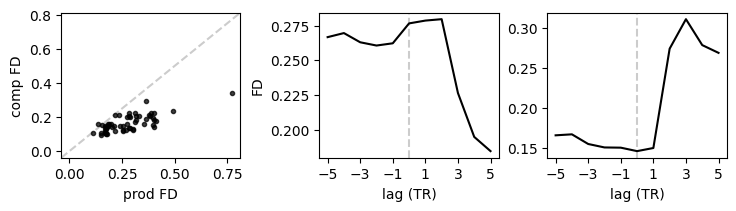

In [112]:
fig, axes = plt.subplots(1, 3, figsize=(7.25, 2), dpi=100, layout='constrained')

ax = axes[0]
ax.scatter(avg_prod_fd, avg_comp_fd, c='k', marker='.', alpha=0.75)
ax.axline((0,0), slope=1, c='k', alpha=0.2, ls='dashed')
ax.set(xlabel='prod FD', ylabel='comp FD')
ax.set_ylim(ax.get_xlim())

ax = axes[1]
ax.plot(lags, avg_epochsP, c='k')
ax.axvline(0, c='k', alpha=0.2, ls='dashed')
ax.set_xticks(lags[::2])
ax.set(xlabel='lag (TR)', ylabel='FD')

ax = axes[2]
ax.plot(lags, avg_epochsC, c='k')
ax.axvline(0, c='k', alpha=0.2, ls='dashed')
ax.set_xticks(lags[::2])
ax.set(xlabel='lag (TR)')

fig.show()

In [100]:
sub_corrs = [pearsonr(fd.squeeze(), bc)[0] for fd, bc in zip(sub_fd, sub_boxcars)]

In [116]:
sub_diffs = np.array(avg_prod_fd) - np.array(avg_comp_fd)

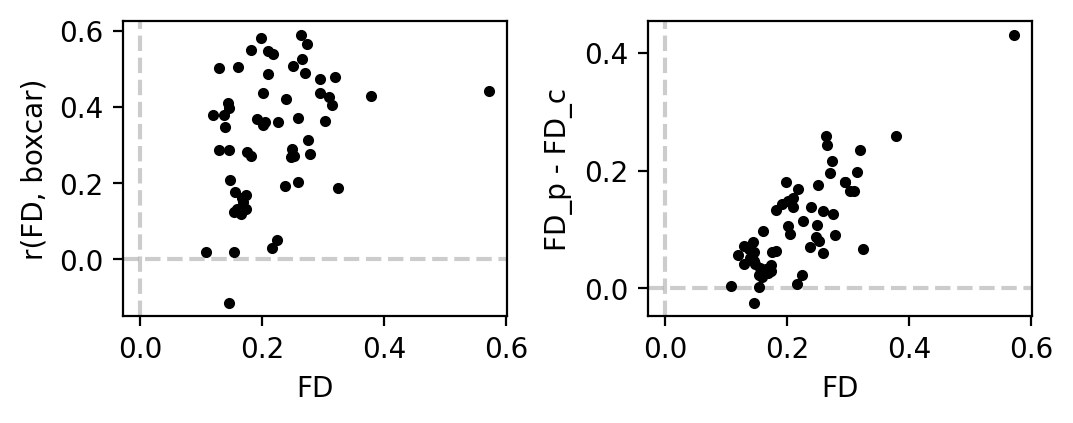

In [124]:
fig, axes = plt.subplots(1, 2, figsize=(5.25, 2), dpi=200, layout='constrained')

ax = axes[0]
ax.scatter(sub_fd.mean(-1), sub_corrs, c='k', marker='.')
ax.set(xlabel='FD', ylabel='r(FD, boxcar)')
ax.axhline(0, c='k', alpha=0.2, ls='dashed')
ax.axvline(0, c='k', alpha=0.2, ls='dashed')

ax = axes[1]
ax.scatter(sub_fd.mean(-1), sub_diffs, c='k', marker='.')
ax.set(xlabel='FD', ylabel='FD_p - FD_c')
ax.axhline(0, c='k', alpha=0.2, ls='dashed')
ax.axvline(0, c='k', alpha=0.2, ls='dashed')


fig.show()

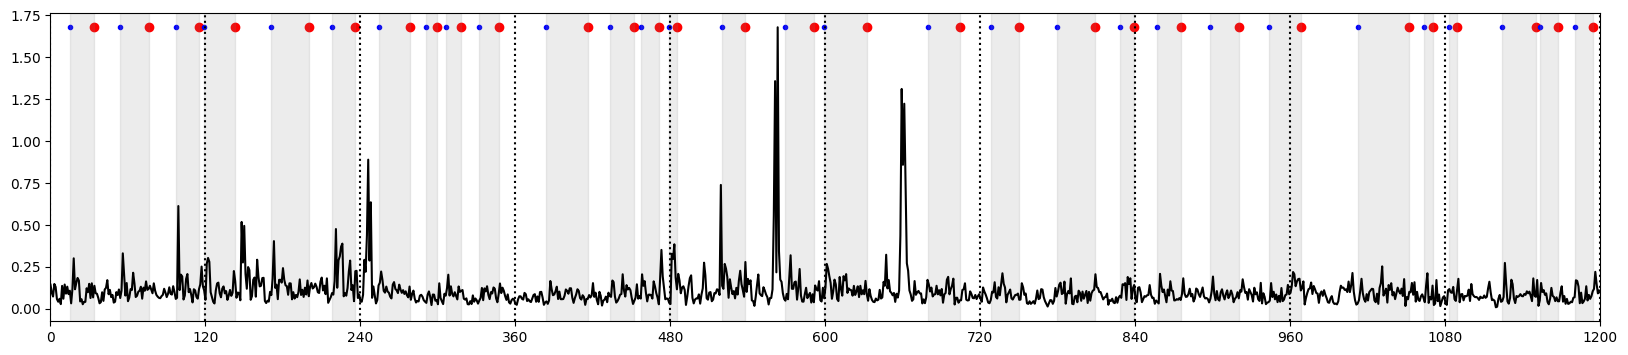

In [42]:
fig, ax = plt.subplots(figsize=(20, 4))

ax.plot(fd, c='k')
# ax.plot(prod_boxcar * fd.max(), c='k', zorder=1, alpha=0.5)

ax.scatter(button_idsA, np.ones_like(button_idsA) * fd.max(), marker='o', c='r')
ax.scatter(button_idsB, np.ones_like(button_idsB) * fd.max(), marker='.', c='b')

# something wrong with this logic? for some subs
switches = [0] + np.nonzero(np.diff(prod_boxcar))[0].tolist()
for i in range(1, len(switches)):
    if i % 2 == 0:
        ax.axvspan(switches[i - 1], switches[i], color="gray", alpha=0.15, zorder=1)

ax.set_xticks(range(0, 1201, 120))
for i in ax.get_xticks():
    ax.axvline(i, c='k', ls='dotted', zorder=1)

# r = 2
# ax.set_xlim(240*r, 240*(r+1))

ax.set_xlim(0, 1200)
fig.show()

In [ ]:
results = []
avg_fd = []
avg_fd_prod = []
avg_fd_comp = []
n_turns = []
for sub_id in tqdm(SUBS_STRANGERS):
    fd = get_confounds(sub_id)
    _, prod_boxcar = get_timinglog_boxcar(sub_id)
    # prodmask = get_transcript_switches(sub_id)
    # result = linregress(prod_boxcar, fd.squeeze())
    result = pearsonr(prod_boxcar, fd.squeeze())
    results.append(result)
    avg_fd.append(fd.mean())
    prod_mask = prod_boxcar.astype(bool)
    avg_fd_prod.append(fd[prod_mask].mean())
    avg_fd_comp.append(fd[~prod_mask].mean())
    n_turns.append(np.sum(np.abs(prod_boxcar)))

df = pd.DataFrame(results)
df.insert(0, 'avg_fd_comp', avg_fd_comp)
df.insert(0, 'avg_fd_prod', avg_fd_prod)
df.insert(0, 'avg_fd', avg_fd)
df.insert(0, 'sub_id', SUBS_STRANGERS)
df.insert(4, 'prod_comp_df_diff', df.avg_fd_prod - df.avg_fd_comp)
df.insert(5, 'n_turns', n_turns)
df.sort_values('pvalue', inplace=True, ascending=False)

In [ ]:
# First, look at subjects that have low correlation with their boxcar
df.head()

In [ ]:
df.tail()

In [ ]:
df.sort_values('prod_comp_df_diff')

### one subject

In [ ]:
sub_id = 156
fd = get_confounds(sub_id)
_, prod_boxcar = get_timinglog_boxcar(sub_id)

In [ ]:
for i in range(0, 1200, 120):
    slc = slice(i, i+120)
    print(i, pearsonr(fd[slc, 0], prod_boxcar[slc]))

## with EAC

In [ ]:
from util.atlas import Atlas

In [ ]:
schaefer = Atlas.schaefer(100)
eac_mask = schaefer.roimask(['17Networks_LH_SomMotB_Aud_1'])
mot_mask = schaefer.roimask(['17Networks_LH_SomMotB_Cent_1'])

In [ ]:
surface_plot(eac_mask.astype(int));
surface_plot(mot_mask.astype(int));

In [ ]:
results = []
for sub_id in tqdm(SUBS_STRANGERS):
    eac_bold = get_raw_bold(sub_id, voxel_mask=eac_mask)
    eac_bold = np.mean(eac_bold, axis=0)
    prodmask = get_prod_mask(sub_id)
    result = linregress(prodmask, eac_bold)
    results.append(result)

df = pd.DataFrame(results)
df.insert(0, 'sub_id', SUBS_STRANGERS)
df.sort_values('pvalue', inplace=True, ascending=False)
df

## one subject

In [ ]:
sub_id = 23 # good
sub_id = 153 # worst
sub_id = 104 # bad
sub_id = 120 # best

sub_id = 53

In [ ]:
fd = get_confounds(sub_id)
_, prod_boxcar = get_timinglog_boxcar(sub_id)

In [ ]:
bold = get_raw_bold(sub_id)
eac_bold = np.mean(bold[eac_mask], axis=0)
mot_bold = np.mean(bold[mot_mask], axis=0)
eac_bold.shape

In [ ]:
dfBold = pd.DataFrame()
dfBold['fd'] = fd.squeeze()
dfBold['boxcar'] = prod_boxcar.squeeze()
dfBold['eac'] = eac_bold
dfBold['mot'] = mot_bold
dfBold.corr()

In [ ]:
scores_fd = correlation_score(bold.T, fd)
scores_bc = correlation_score(bold.T, prod_boxcar[:, None])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
surface_plot(scores_fd, fig=fig, ax=axes[0], title='r(FD)', inflation=150)#, surf_lh_fn=None)
surface_plot(scores_bc, fig=fig, ax=axes[1], title='r(boxcar)', inflation=150)#, surf_lh_fn=None)
fig.show()